In [1]:
!pip install seaborn

/home/user/anaconda3/envs/graphspiking/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



====== Configuration ======
Evaluation #4:		5-fold reduced Train (A-G) / Test (H-L)
Regression task:	strength
Hyper-parameters :	0.json

====== Training / Testing ======
fold-1		completed
fold-2		completed
fold-3		completed
fold-4		completed
fold-5		completed
Processing time: 1136.58 seconds

====== RESULTS ======
Spiking activity is :
tensor([0.2609], device='cuda:0', grad_fn=<CopySlices>)
tensor([0.0457], device='cuda:0', grad_fn=<CopySlices>)
tensor([0.1193], device='cuda:0', grad_fn=<CopySlices>)
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
(MeanARE, MaxARE):	(1.95, 11.31)


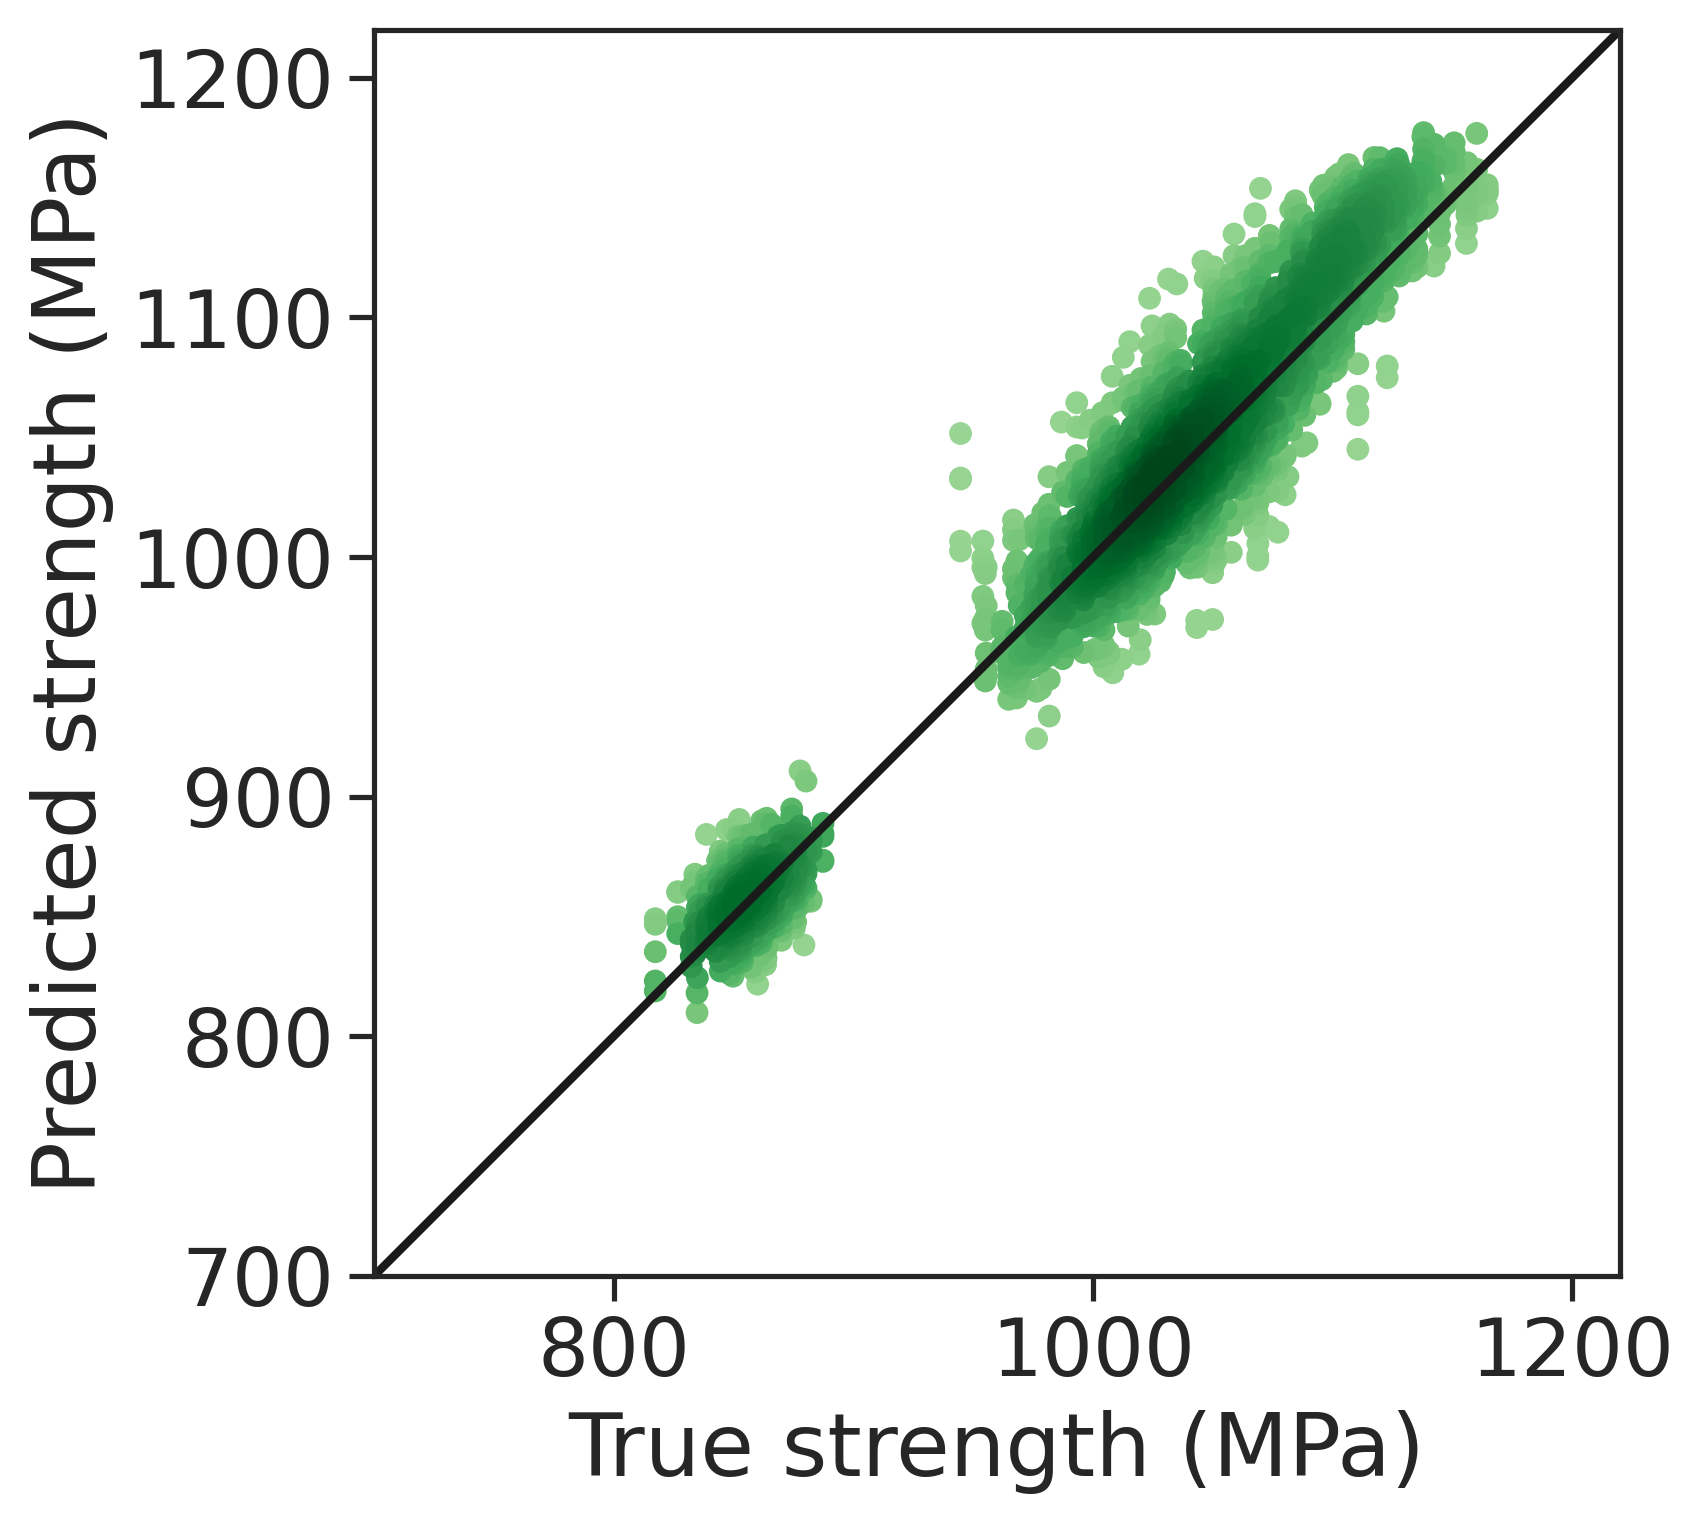

In [2]:
import argparse
import json
import os
import random
import sys

import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from torch_geometric.nn import Linear, SAGEConv, global_mean_pool
import time
import snntorch as snn
from utils import *


def seed_all(seed):
    '''
    Set random seeds for reproducability
    '''
    if not seed:
        seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class GNN(torch.nn.Module):
    '''
    Graph Neural Network
    '''
    def __init__(self, N_fl1, N_mpl, N_fl2, N_fl3):
        super(GNN, self).__init__()
        self.pre = Linear(5, N_fl1)
        self.conv1 = SAGEConv(N_fl1, N_mpl, normalize=True)
        self.conv2 = SAGEConv(N_mpl, N_mpl, normalize=True)
        self.post1 = Linear(N_mpl, N_fl2)
        self.post2 = Linear(N_fl2, N_fl3)
        self.out = Linear(N_fl3, 1)
        
        # Spiking Neurons
        # Neuron 1
        beta_1 = torch.rand(32)
        thr_1 = torch.rand(32)
        self.lif_1 = snn.Leaky(beta = beta_1, learn_beta = True, threshold = thr_1, learn_threshold=True, reset_mechanism='zero')
        
        beta_2 = torch.rand(64)
        thr_2 = torch.rand(64)
        self.lif_2 = snn.Leaky(beta = beta_2, learn_beta = True, threshold = thr_2, learn_threshold=True, reset_mechanism='zero')
        
        beta_3 = torch.rand(64)
        thr_3 = torch.rand(64)
        self.lif_3 = snn.Leaky(beta = beta_3, learn_beta = True, threshold = thr_3, learn_threshold=True, reset_mechanism='zero')
        
        beta_4 = torch.rand(64)
        thr_4 = torch.rand(64)
        self.lif_4 = snn.Leaky(beta = beta_4, learn_beta = True, threshold = thr_4, learn_threshold=True, reset_mechanism='zero')
        
        beta_5 = torch.rand(16)
        thr_5 = torch.rand(16)
        self.lif_5 = snn.Leaky(beta = beta_5, learn_beta = True, threshold = thr_5, learn_threshold=True, reset_mechanism='zero')
        
#         beta_6 = torch.rand(hidden_dim)
#         thr_6 = torch.rand(hidden_dim)
#         self.lif_6 = snn.Leaky(beta = beta_6, learn_beta = True, threshold = thr_6, learn_threshold=True, reset_mechanism='zero')
        
#         beta_7 = torch.rand(hidden_dim)
#         thr_7 = torch.rand(hidden_dim)
#         self.lif_7 = snn.Leaky(beta = beta_7, learn_beta = True, threshold = thr_7, learn_threshold=True, reset_mechanism='zero')
        
        

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        mem_1 = self.lif_1.init_leaky()
        mem_2 = self.lif_2.init_leaky()
        mem_3 = self.lif_3.init_leaky()
        mem_4 = self.lif_4.init_leaky()
        mem_5 = self.lif_5.init_leaky()
        # mem_6 = self.lif_6.init_leaky()
        # mem_7 = self.lif_7.init_leaky()
        
        s1_sum = torch.zeros([1]).to(device)
        s2_sum = torch.zeros([1]).to(device)
        s3_sum = torch.zeros([1]).to(device)
        s4_sum = torch.zeros([1]).to(device)
        s5_sum = torch.zeros([1]).to(device)
        
        # Pre Processing Linear Layer
        # Replacing ReLU with spiking
        
        # x = F.relu(self.pre(x))
        x1 = self.pre(x)
        spk_in1, mem_1 = self.lif_1(x1, mem_1)
        x = spk_in1*x1
        s1_sum[0] += torch.sum(spk_in1)/spk_in1.numel()
        
        # 1. Obtain node embeddings
        # Replacing ReLU with spiking
        # x = F.relu(self.conv1(x, edge_index))
        x2 = self.conv1(x, edge_index)
        spk_in2, mem_2 = self.lif_2(x2, mem_2)
        x = spk_in2*x2
        s2_sum[0] += torch.sum(spk_in2)/spk_in2.numel()
        
        # x = F.relu(self.conv2(x, edge_index))
        x3 = self.conv2(x, edge_index)
        spk_in3, mem_3 = self.lif_3(x3, mem_3)
        x = spk_in3*x3
        s3_sum[0] += torch.sum(spk_in3)/spk_in3.numel()
        
        # 2. Readout layer
        x = global_mean_pool(x, batch)
        
        # 3. Apply Fully Connected Layers
        # Replacing ReLU with spiking
        x = F.relu(self.post1(x))
        # x4 = self.post1(x)
        # spk_in4, mem_4 = self.lif_4(x4, mem_4)
        # x = spk_in4*x4
        # s4_sum[0] += torch.sum(spk_in4)/spk_in4.numel()
        
        x = F.relu(self.post2(x))
        # x5 = self.post2(x)
        # spk_in5, mem_5 = self.lif_5(x5, mem_5)
        # x = spk_in5*x5
        # s5_sum[0] += torch.sum(spk_in5)/spk_in5.numel()
        
        x = self.out(x)
        return x, s1_sum, s2_sum, s3_sum, s4_sum, s5_sum


def init_model():
    '''
    Initialize model
    '''
    seed_all(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNN(N_fl1, N_mpl, N_fl2, N_fl3).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=l_rate, weight_decay=w_decay)
    return model, optimizer


def train(model, optimizer, train_loader, val_loader, n_epoch, prop, config, fold):
    '''
    Train GNN
    '''
    filename = f'{output_dir}/eval-{eval}_config-{config}_fold-{fold}_loss_history.txt'
    output = open(filename, "w")

    print('Epoch Training_MSE Validation_MSE', file=output, flush=True)

    seed_all(seed)
    for epoch in range(n_epoch):
        model.train()
        # Train batches
        for train_batch in train_loader:
            train_batch = train_batch.to(device)
            train_pred, s1_t, s2_t, s3_t, s4_t, s5_t = model(train_batch)
            train_true = getattr(train_batch, prop)
            train_loss = F.mse_loss(train_pred, train_true)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Evaluate
        val_pred, val_true, s1_test, s2_test, s3_test, s4_test, s5_test = test(model, val_loader, prop)
        val_loss = F.mse_loss(val_pred, val_true)
        print(f'{epoch:d}, {train_loss:e}, {val_loss:e}', file=output, flush=True)
    return


def test(model, data_loader, prop):
    '''
    Test GNN
    '''
    seed_all(seed)
    model.eval()
    data = next(iter(data_loader)).to(device)
    pred, s1_test, s2_test, s3_test, s4_test, s5_test = model(data)
    true = getattr(data, prop)
    return pred, true, s1_test, s2_test, s3_test, s4_test, s5_test


if __name__ == '__main__':
    
    if 'ipykernel' in sys.modules:
        args = ['--eval', '4', '--prop', 'strength', '--config_dir', '/DATA/graphspiking/graph_spiking/PolyGRAPH-main/config/', '--config', '0', '--output_dir', '/DATA/graphspiking/graph_spiking/PolyGRAPH-main/meanARE_outputs/output_vsn2/', '--seed', '42']
    else:
        args = sys.argv[1:]
        
    parser = argparse.ArgumentParser()
    parser.add_argument('--eval', type=int, default=4)
    parser.add_argument('--prop', type=str, default='strength')
    parser.add_argument('--config_dir', type=str, default='/DATA/graphspiking/graph_spiking/PolyGRAPH-main/config/')
    parser.add_argument('--config', type=int, default=0)
    parser.add_argument('--output_dir', type=str, default='/DATA/graphspiking/graph_spiking/PolyGRAPH-main/strength_out/output_vsn2/')
    parser.add_argument('--seed', type=int, default=42)

    args = parser.parse_args(args)
    eval = args.eval
    prop = args.prop
    config_dir = args.config_dir
    config = args.config
    output_dir = args.output_dir
    seed = args.seed

    if not os.path.exists(config_dir):
        os.makedirs(config_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config_name = config_dir + str(config) + '.json'
    with open(config_name, 'r') as h:
        params = json.load(h)

    l_rate = params['l_rate']
    w_decay = params['w_decay']
    n_epoch = params['n_epoch']
    b_size = params['b_size']
    N_fl1 = params['N_fl1']
    N_mpl = params['N_mpl']
    N_fl2 = params['N_fl2']
    N_fl3 = params['N_fl3']

    # Set seeds for complete reproducability
    seed_all(seed)

    # Define the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    cases = ['10-fold CV (A-G)',
             'Train (A-G) / Test (A-G)',
             'Train (A-G) / Test (H-L)',
             '5-fold reduced Train (A-G) / Test (H-L)']

    print('\n====== Configuration ======')
    print(f'Evaluation #{eval}:\t\t{cases[eval-1]}')
    print(f'Regression task:\t{prop}')
    print(f'Hyper-parameters :\t{config}.json')

# *************************************************************************** #
    print('\n====== Training / Testing ======')
    start = time.time()

    # Eval == 1 or 4 : 10-fold CV (A-G) or 5-fold Train Test (A-G), (H-L)
    if eval in [1, 4]:
        preds = torch.empty((0, 1)).to(device)
        trues = torch.empty((0, 1)).to(device)

        # 10-fold on 90 RVEs from Train/Val Set
        if eval == 1:
            kfold = np.random.choice(90, [10, 9], replace=False)
            num_folds = 10

        # 5 trainings on 20 RVEs, Entire A-G set considered
        else:
            kfold = np.random.choice(100, [5, 20], replace=False)
            num_folds = 5

        for k in range(num_folds):
            print('fold-{}'.format(k+1), end='')
            kfold = np.concatenate([kfold[1:, :], [kfold[0, :]]])
            kfold_ids = kfold.flatten()

            # Load data
            train_loader, val_loader = get_data(eval, kfold_ids, b_size)

            # Define model and optimizer
            model, optimizer = init_model()

            # Train model
            train(model, optimizer, train_loader,
                  val_loader, n_epoch, prop, config, k)

            # Test model
            k_pred, k_true, s1_test, s2_test, s3_test, s4_test, s5_test = test(model, val_loader, prop)

            # Record predictions
            preds = torch.cat([preds, k_pred])
            trues = torch.cat([trues, k_true])

            # Save model
            torch.save(
                model, f'{output_dir}/eval-{eval}_config-{config}_prop-{prop}_fold-{k+1}_checkpoint.pth')
            print('\t\tcompleted')

# *************************************************************************** #
    # Eval == 2 or 3 : Train/Test (A-G) or Train/Test (A-G)/(H-L)
    else:
        # Load data
        train_loader, test_loader = get_data(eval, [], b_size)

        # Define model and optimizer
        model, optimizer = init_model()

        # Train model
        train(model, optimizer, train_loader, test_loader,
              n_epoch, prop, config, 'NA')

        # Test Model
        preds, trues, s1_test, s2_test, s3_test, s4_test, s5_test = test(model, test_loader, prop)

        # Save model
        torch.save(
            model, f"{output_dir}/eval-{eval}_config-{config}_prop-{prop}_fold-{'NA'}_checkpoint.pth")

    print(f'Processing time: {time.time()-start:.2f} seconds')
# *************************************************************************** #
    # Report and Visualize predictions

    print('\n====== RESULTS ======')
    preds = scaler[prop].inverse_transform(
        preds.detach().detach().cpu().numpy())
    trues = scaler[prop].inverse_transform(
        trues.detach().detach().cpu().numpy())
    meanARE, maxARE = mean_maxARE(preds, trues)
    
    print("Spiking activity is :" )
    print(s1_test)
    print(s2_test)
    print(s3_test)
    print(s4_test)
    print(s5_test)

    print(f'(MeanARE, MaxARE):\t({meanARE}, {maxARE})')
    plot_results(preds, trues, output_dir, eval, config, prop)
